In [308]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
import matplotlib.pyplot as plt

# plotting parameters
plt.rcParams["font.family"] = "serif"
plt.rcParams['lines.linewidth'] = 4.0
save_figures = True

In [309]:
# Gaussian process habituation model
def gp_habituation(t, x, length_scale=1, alpha=0.3, threshold=0.5):
    gp = GaussianProcessRegressor(kernel=RBF(length_scale=length_scale), alpha=alpha, optimizer=None)
    gp.fit(t,x)
    test = t[-1].reshape(1,t.shape[1])
    xhat, sd = gp.predict(test, return_std=True)
    response = norm.cdf(xhat,threshold,sd)
    return response, xhat, sd

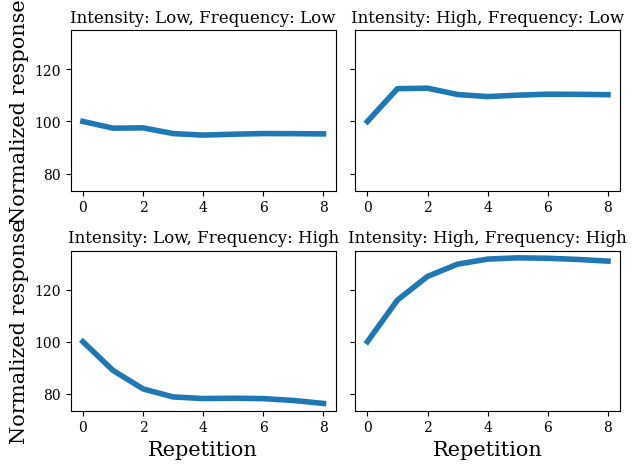

In [328]:
# Frequency and intensity dependence

N = 10                      # number of repetitions
frequencies = [2,10]
intensities = [0.3,0.7]
labels = ["Low","High"]

response = np.zeros(N-1)
fig, ax = plt.subplots(2, 2, sharey=True)

for i, intensity in enumerate(intensities):
    for j, freq in enumerate(frequencies):
        for n in range(1,N):
            x = np.ones(n)*intensity
            t = np.linspace(1,n,n).reshape(n,1)/freq
            response[n-1], xhat, sd = gp_habituation(t, x)
    
        response = 100*response/response[0] # normalize response (as in Groves et al., 1969)
        ax[j,i].plot(response)
        ax[j,i].set_title('Intensity: '+labels[i]+', Frequency: '+labels[j])

ax[1,0].set_xlabel("Repetition")
ax[1,1].set_xlabel("Repetition")
ax[0,0].set_ylabel("Normalized response")
ax[1,0].set_ylabel("Normalized response")
fig.tight_layout()

if save_figures:
    plt.savefig("../figures/frequency_intensity.pdf", format="pdf", bbox_inches="tight")

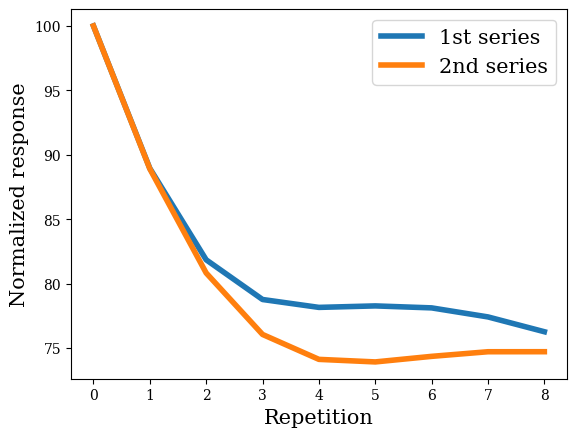

In [327]:
# Potentiation

freq = 10
intensity = 0.3
delay = 1
N = 10

response = np.zeros((N-1,2))

# initial series
for n in range(1,N):
    x = np.ones(n)*intensity
    t = np.linspace(1,n,n).reshape(n,1)/freq
    response[n-1,0], xhat, sd = gp_habituation(t, x)

# repeated series
for n in range(1,N):
    x = np.concatenate((np.ones(N)*intensity,np.ones(n)*intensity))
    t = np.concatenate((np.linspace(1,N,N)/freq,N/freq+delay+np.linspace(1,n,n)/freq)).reshape(n+N,1)
    response[n-1,1], xhat, sd = gp_habituation(t, x)
    
response = 100*response/response[0]

plt.plot(response)
plt.legend(["1st series","2nd series"], fontsize=15)
plt.xlabel("Repetition", fontsize=15)
plt.ylabel("Normalized response", fontsize=15)

if save_figures:
    plt.savefig("../figures/potentiation.pdf", format="pdf", bbox_inches="tight")

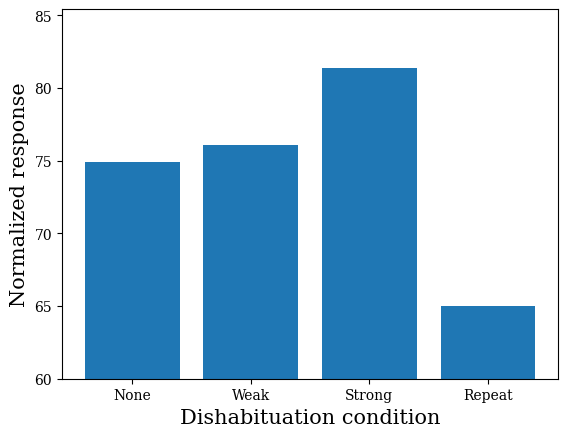

In [326]:
# Dishabituation

freq = 10
intensity = 0.3

response = np.zeros(4)

# control response
N = 1
x = np.ones(N)*intensity
t = np.linspace(1,N,N).reshape(N,1)/freq
s = np.ones(N).reshape(N,1)
z = np.concatenate((t,s),axis=1)
response0, xhat, sd = gp_habituation(z, x) 

N = 10

# no dishabituation stimulus
x = np.ones(N)*intensity
t = np.linspace(1,N,N).reshape(N,1)/freq
s = np.ones(N).reshape(N,1)
z = np.concatenate((t,s),axis=1)
response[0], xhat, sd = gp_habituation(z, x)

# weak dishabituation stimulus
p = (0.5*(N-1)+0.5*N)/freq
z = np.insert(z,N-1,np.array((p, 2)),0)
x = np.insert(x,N-1,intensity)
response[1], xhat, sd = gp_habituation(z, x)

# strong dishabituation stimulus
x[-2] = intensity*2
response[2], xhat, sd = gp_habituation(z, x)

# repeated dishabituation (habituation of dishabituation)
t = np.insert(t,N-1,p,0)
s = np.insert(s,N-1,2,0)
t = np.concatenate((t,t+delay/freq)).reshape((N+1)*2,1)
s = np.concatenate((s,s)).reshape((N+1)*2,1)
x = np.concatenate((x,x)).reshape((N+1)*2,1)
z = np.concatenate((t,s),axis=1)
response[3], xhat, sd = gp_habituation(z, x)

response = 100*response/response0   # normalize response

labels = ["None", "Weak", "Strong", "Repeat"]
plt.bar(labels,response)
plt.ylim(bottom=60)
plt.ylabel("Normalized response", fontsize=15)
plt.xlabel("Dishabituation condition", fontsize=15)

if save_figures:
    plt.savefig("../figures/dishabituation.pdf", format="pdf", bbox_inches="tight")

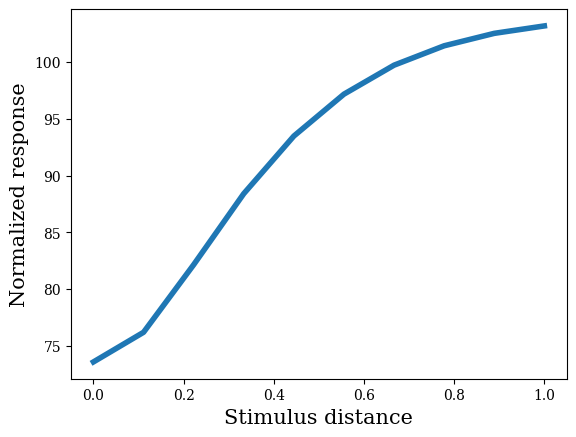

In [323]:
# Stimulus specificity

N = 10
stimulus = np.linspace(1,2,10)
distance = stimulus - 1
response = np.zeros(len(stimulus))

for i,s2 in enumerate(stimulus):
    x = np.ones(N+1)*intensity
    t = np.linspace(1,N+1,N+1).reshape(N+1,1)/freq
    s = np.ones(N+1).reshape(N+1,1)
    s[-1] = s2
    z = np.concatenate((t,s),axis=1)
    response[i], xhat, sd = gp_habituation(z, x)
    
response = 100*response/response0   # normalize response

plt.plot(distance,response)
plt.xlabel("Stimulus distance", fontsize=15)
plt.ylabel("Normalized response", fontsize=15)

if save_figures:
    plt.savefig("../figures/stimulus_specificity.pdf", format="pdf", bbox_inches="tight")

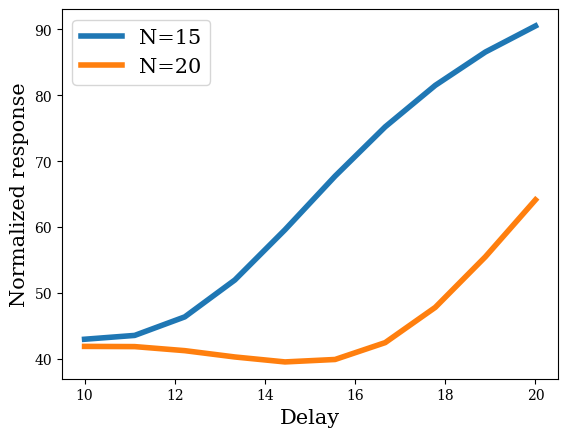

In [321]:
# Spontaneous recovery after asymptotic habituation

N = [15,20]
delay = np.linspace(10,20,10)

response = np.zeros((len(delay),len(N)))

n = 1
x = np.ones(n)*intensity
t = np.linspace(1,n,n).reshape(n,1)/freq
response0, xhat, sd = gp_habituation(t, x)

for i,n in enumerate(N):
    for j,d in enumerate(delay):
        x = np.ones(n+1)*intensity
        t = np.append(np.linspace(1,n,n),d).reshape(n+1,1)/freq
        response[j,i], xhat, sd = gp_habituation(t, x)

response = 100*response/response0   # normalize response

plt.plot(delay,response)
plt.legend(["N="+str(N[0]),"N="+str(N[1])], fontsize=15)
plt.xlabel("Delay", fontsize=15)
plt.ylabel("Normalized response", fontsize=15)

if save_figures:
    plt.savefig("../figures/spontaneous_recovery.pdf", format="pdf", bbox_inches="tight")

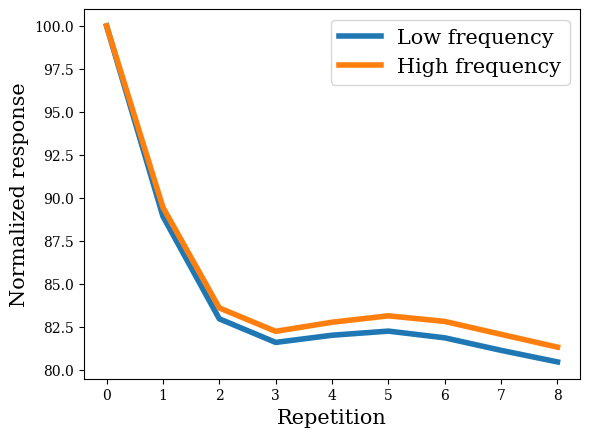

In [322]:
# Frequency dependence of rehabituation

frequencies = [2,10]
freq_test = 6
intensity = 0.3
delay = 1
N = 10

response = np.zeros((N-1,2))

# repeated series
for i,freq in enumerate(frequencies):
    for n in range(1,N):
        x = np.concatenate((np.ones(N)*intensity,np.ones(n)*intensity))
        t = np.concatenate((np.linspace(1,N,N)/freq,N/freq+delay+np.linspace(1,n,n)/freq_test)).reshape(n+N,1)
        response[n-1,i], xhat, sd = gp_habituation(t, x)
    
response = 100*response/response[0]

plt.plot(response)
plt.legend(["Low frequency","High frequency"], fontsize=15)
plt.xlabel("Repetition", fontsize=15)
plt.ylabel("Normalized response", fontsize=15)

if save_figures:
    plt.savefig("../figures/frequency_rehabituation.pdf", format="pdf", bbox_inches="tight")

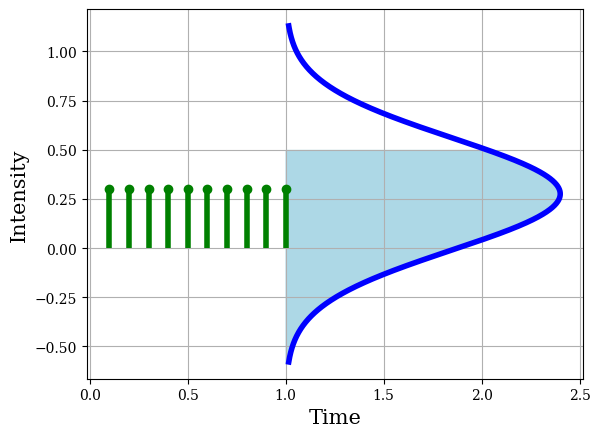

In [319]:
# Illustration

intensity = 0.3
freq = 10
N = 10
threshold = 0.5

t = np.linspace(1,N,N).reshape(N,1)/freq
stimuli = np.ones(N)*intensity

# gp = GaussianProcessRegressor(kernel=RBF(length_scale=1), alpha=0.3, optimizer=None)
# gp.fit(t,stimuli)
# m, sd = gp.predict(t[-1].reshape(1,1), return_std=True)
# p = norm.cdf(m,threshold,sd)
response, xhat, sd = gp_habituation(t, stimuli) 

# Generate data for normal distribution
xhat = xhat[0]
sd = sd[0]
ymin = xhat - sd*3
ymax = xhat + sd*3
x = np.linspace(ymin, ymax, 1000)
y = (1 / (sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - xhat) / sd) ** 2)

# Plot the normal distribution
plt.plot(y + t[-1], x, color='blue')

# Shade the area under the curve
shade_start = ymin
shade_end = threshold
plt.fill_betweenx(x, t[-1], y + t[-1], where=(x >= shade_start) & (x <= shade_end), color='lightblue')

# Customize plot
plt.xlabel('Time', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
plt.grid(True)

# Add a stem plot
plt.stem(t, stimuli, linefmt='g-', markerfmt='go', basefmt=' ', bottom=0)

if save_figures:
    plt.savefig("../figures/illustration.pdf", format="pdf", bbox_inches="tight")